Evaluation of pouch cell stress

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

We first define the extra parameters in PyBamm, and define the stress fucntions:

In [2]:
# Define parameters using PyBaMM's parameter interface
E_C = pybamm.Parameter("Positive electrode Young modulus [Pa]")
E_A = pybamm.Parameter("Negative electrode Young modulus [Pa]")
E_S = pybamm.Parameter("Separator Young modulus [Pa]")
a_C = pybamm.Parameter("Positive electrode expansion coefficient")
a_A = pybamm.Parameter("Negative electrode expansion coefficient")
v_C = pybamm.Parameter("Positive electrode Poisson ratio")
v_A = pybamm.Parameter("Negative electrode Poisson ratio")
t_C = pybamm.Parameter("Positive electrode thickness [m]")
t_S = pybamm.Parameter("Separator thickness [m]")
t_A = pybamm.Parameter("Negative electrode thickness [m]")
U = pybamm.Parameter("Total thickness relaxation [m]") #This is the total thickness variation. Set to 0 for a battery clamped when fully discharged (stochiometry of anode = 0).
N = pybamm.Parameter("Number of layers") 



# Set parameter values
parameter_values = pybamm.ParameterValues("Marquis2019")

parameter_values.update({"Positive electrode Young modulus [Pa]": 10**9}, check_already_exists=False)
parameter_values.update({"Negative electrode Young modulus [Pa]": 10**9}, check_already_exists=False)
parameter_values.update({"Positive electrode expansion coefficient": 0}, check_already_exists=False)
parameter_values.update({"Negative electrode expansion coefficient": 6.5/300}, check_already_exists=False) #This is the linear expansion coefficient of the anode. The cathode is assumed to be 0.
parameter_values.update({"Negative electrode Poisson ratio": 0.2}, check_already_exists=False)
parameter_values.update({"Positive electrode Poisson ratio": 0.1}, check_already_exists=False)
parameter_values.update({"Separator thickness [m]": 0.2e-05},check_already_exists=False)
parameter_values.update({"Separator Young modulus [Pa]": 0.5 * 10**9},check_already_exists=False)
parameter_values.update({"Number of layers": pybamm.Scalar(10)}, check_already_exists=False)
parameter_values.update({"Total thickness relaxation [m]": pybamm.Scalar(0)}, check_already_exists=False)
parameter_values["Positive current collector thickness [m]"] = 1e-05
parameter_values["Negative current collector thickness [m]"] = 1e-05
parameter_values["Separator thickness [m]"] = 2e-05


We now define the stress using asymptotic results for article Giudici et al. 2025, for a cell clamped with U=0.

In [3]:
# Define the swelling in asnode and cathode
def swelling_A(stoc):
    return a_A * stoc

def swelling_C(stoc):
    return a_C * stoc

du = U/N
# this is the total thickness variation divided by the number of layers. We shall set U to vanish.



# Define custom stress functions using PyBaMM expressions

#Throgh-cell stress
def sigma_xx(alpha_A, alpha_C):
    return (du - alpha_A * ((1 + v_A)/(1-v_A))*t_A - alpha_C * ((1 + v_C)/(1-v_C))*t_C)/(((1 + v_A)*(1-2 * v_A)*t_A)/((1-v_A)*E_A)+((1 + v_C)*(1-2 * v_C)*t_C)/((1-v_C)*E_C)+ t_S/E_S)

#In-plane stress in the anode
def sigma_A_yy_zz(alpha_A, alpha_C):
    return (v_A/(1-v_A)) * sigma_xx(alpha_A, alpha_C) - (E_A/(1-v_A)) * alpha_A

#In-plane stress in the Cathode
def sigma_C_yy_zz(alpha_A, alpha_C):
    return (v_C/(1-v_C)) * sigma_xx(alpha_A, alpha_C) - (E_C/(1-v_C)) * alpha_C


We now run a pybamm code that simulates charging discharging of a battery. We used potential pair model for CC to include y,z variation in lithiation in-plane.

In [4]:
# Model definition and parameters
model = pybamm.lithium_ion.SPM(
    options={
        "cell geometry": "pouch",
        "current collector": "potential pair",
        "dimensionality": 2,
        "thermal": "x-lumped",
    },
)


# Retrieve stoichiometry from model variables
X_p = model.variables['Positive electrode stoichiometry']
X_n = model.variables['Negative electrode stoichiometry']

# Register stress variables
model.variables["Negative electrode in-plane stress (yy,zz) [Pa]"] = sigma_A_yy_zz(swelling_A(X_n), swelling_C(X_p))
model.variables["Positive electrode in-plane stress (yy,zz) [Pa]"] = sigma_C_yy_zz(swelling_A(X_n), swelling_C(X_p))
model.variables["Negative electrode through-cell stress xx [Pa]"] = sigma_xx(swelling_A(X_n), swelling_C(X_p))
model.variables["Positive electrode through-cell stress xx [Pa]"] = sigma_xx(swelling_A(X_n), swelling_C(X_p))
model.variables["Positive electrode expansion strain"] = swelling_C(X_p)
model.variables["Negative electrode expansion strain"] = swelling_A(X_n)

# mesh points
var_pts = {
    "x_n": 10,  # negative electrode
    "x_s": 10,  # separator
    "x_p": 10,  # positive electrode
    "r_n": 10,  # negative particle
    "r_p": 10,  # positive particle
    "y": 10,  # current collector y-direction
    "z": 10,  # current collector z-direction
}

# current
I_1C = parameter_values["Nominal cell capacity [A.h]"]  # 1C current is nom. cap. / 1hr


def current(t):
    # discharge at 1C, rest for 1 hour, then charge at 1C
    return 2* I_1C * (t < 3600/2) - 2 * I_1C * (t > 7200/2)


parameter_values["Current function [A]"] = current

# Setup solver and simulation
solver = pybamm.CasadiSolver(atol=1e-6, rtol=1e-3, root_tol=1e-3, mode="safe")

sim = pybamm.Simulation(
    model, parameter_values=parameter_values, solver=solver,
)    
sol = sim.solve(np.linspace(0, 10800, 10801))

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': 'cm'  # Short for Computer Modern, the default LaTeX font
})

Plot some of the simualtions results:

Text(0, 0.5, 'Negative electrode stoichimetry')

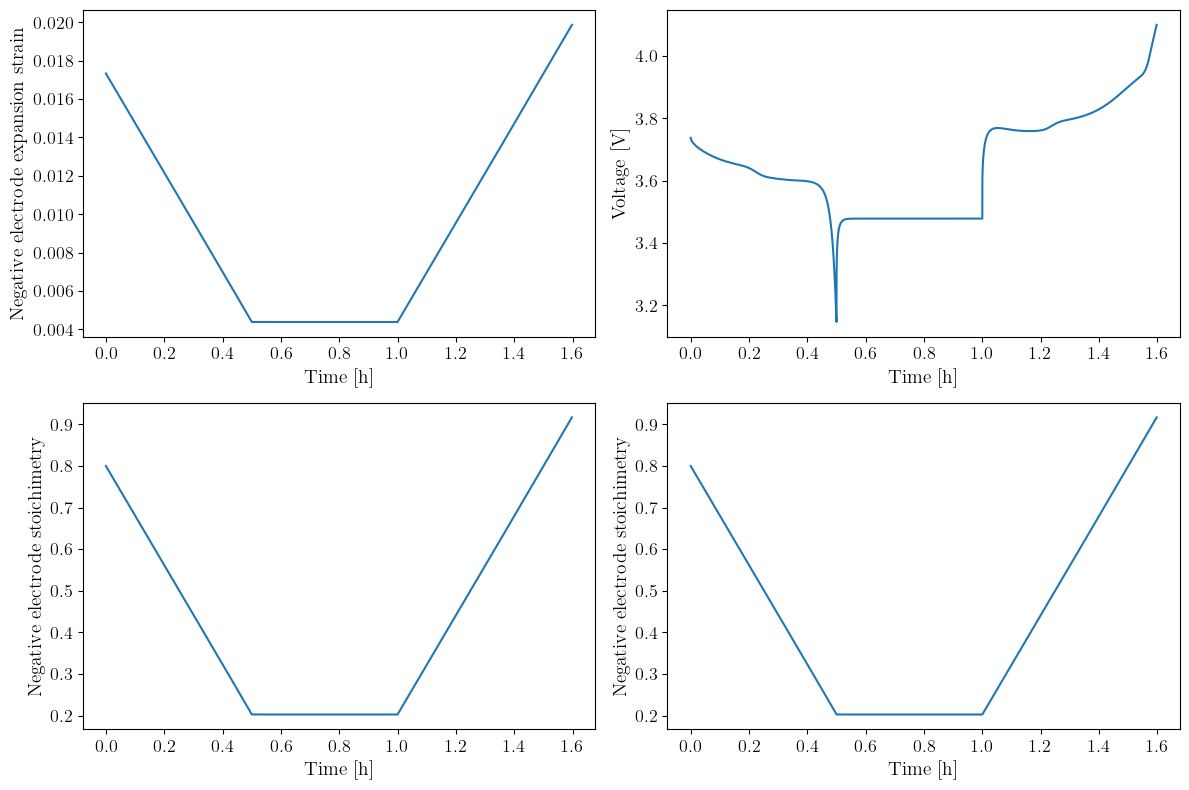

In [5]:

import matplotlib.pyplot as plt

plt.rc('axes', labelsize=14)  
plt.rc('xtick', labelsize=13)    
plt.rc('ytick', labelsize=13)  
plt.rc('legend', fontsize=13)   

fig, ax = plt.subplots(2, 2,figsize=(12, 8), tight_layout=True)

ax[0,0].plot(
    sol["Time [h]"].entries, 
    sol["Negative electrode expansion strain"].entries[4,4],
    label=sol.all_models[0].name
)    
ax[0,1].plot(
    sol["Time [h]"].entries, 
    sol["Voltage [V]"].entries,
    label=sol.all_models[0].name
) 
ax[1,0].plot(
    sol["Time [h]"].entries, 
    sol['Negative electrode stoichiometry'].entries[4,4],
    label=sol.all_models[0].name
)   
ax[1,1].plot(
    sol["Time [h]"].entries, 
    sol['Negative electrode stoichiometry'].entries[4,4],
    label=sol.all_models[0].name
)        

ax[0,0].set_xlabel("Time [h]")    
ax[0,0].set_ylabel("Negative electrode expansion strain")  
ax[0,1].set_xlabel("Time [h]")    
ax[0,1].set_ylabel("Voltage [V]")
ax[1,0].set_xlabel("Time [h]")    
ax[1,0].set_ylabel("Negative electrode stoichimetry")  
ax[1,1].set_xlabel("Time [h]")    
ax[1,1].set_ylabel("Negative electrode stoichimetry")

Defince costum plut to show spatial variation of stresses:

In [6]:
# dEfine custom plot function
def plot(solution,component, t):
    # Mesh for plotting
    L_y = parameter_values.evaluate(pybamm.Parameter("Electrode width [m]"))
    L_z = parameter_values.evaluate(pybamm.Parameter("Electrode height [m]"))
    y_plot = np.linspace(0, L_y, 101)
    z_plot = np.linspace(0, L_z, 101)
    
    # Evaluate stress and expansion variables at the given time
    plot_array = np.array(solution[component](y=y_plot, z=z_plot, t=t)).T

    # Plot the contour
    plt.figure(figsize=(3, 2), dpi=300)
    contour = plt.contourf(y_plot, z_plot,  plot_array, levels=100, cmap='viridis')  # Using the 'viridis' colormap
    plt.colorbar(contour)
    plt.xlabel(r"$y$ [m]")
    plt.ylabel(r"$z$ [m]")
    plt.show()


We Plot the stoichiometry, the through-cell stress, the in plane stress in the anode, and the shear stresses half way through the innitial discharge:

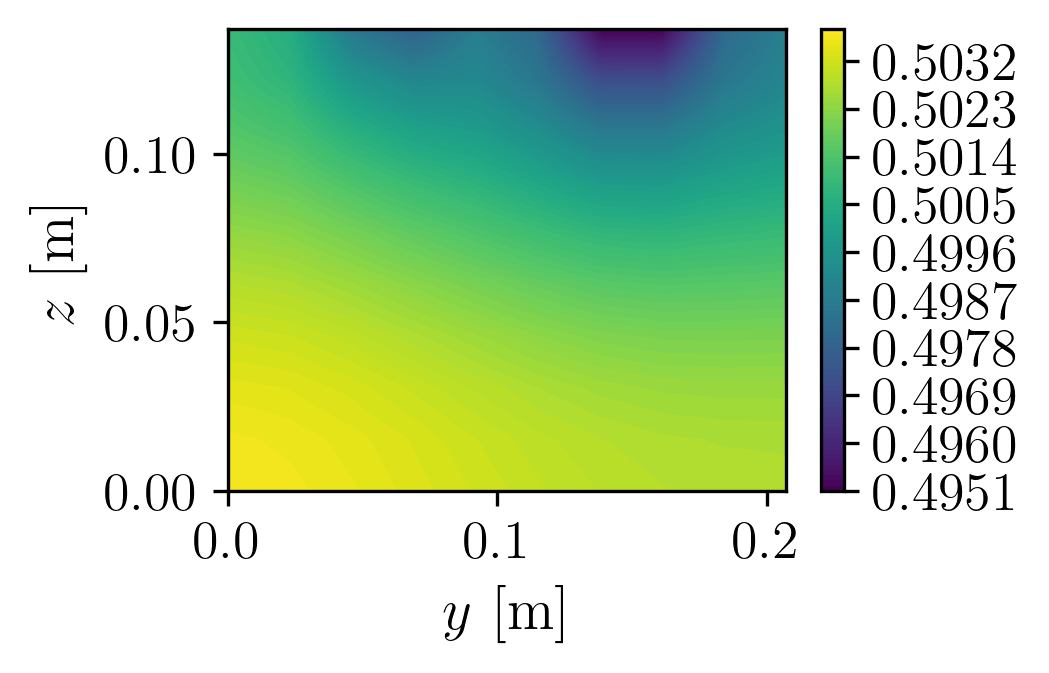

In [7]:
t=60*15

# Mesh for plotting
L_y = parameter_values.evaluate(pybamm.Parameter("Electrode width [m]"))
L_z = parameter_values.evaluate(pybamm.Parameter("Electrode height [m]"))
y_plot = np.linspace(0, L_y, 101)
z_plot = np.linspace(0, L_z, 101)
    
# Evaluate stress and expansion variables at the given time
plot_array = np.array(sol["Negative electrode stoichiometry"](y=y_plot, z=z_plot, t=t)).T

# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(y_plot, z_plot,  plot_array, levels=100, cmap='viridis')  # Using the 'viridis' colormap
plt.colorbar(contour)
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()

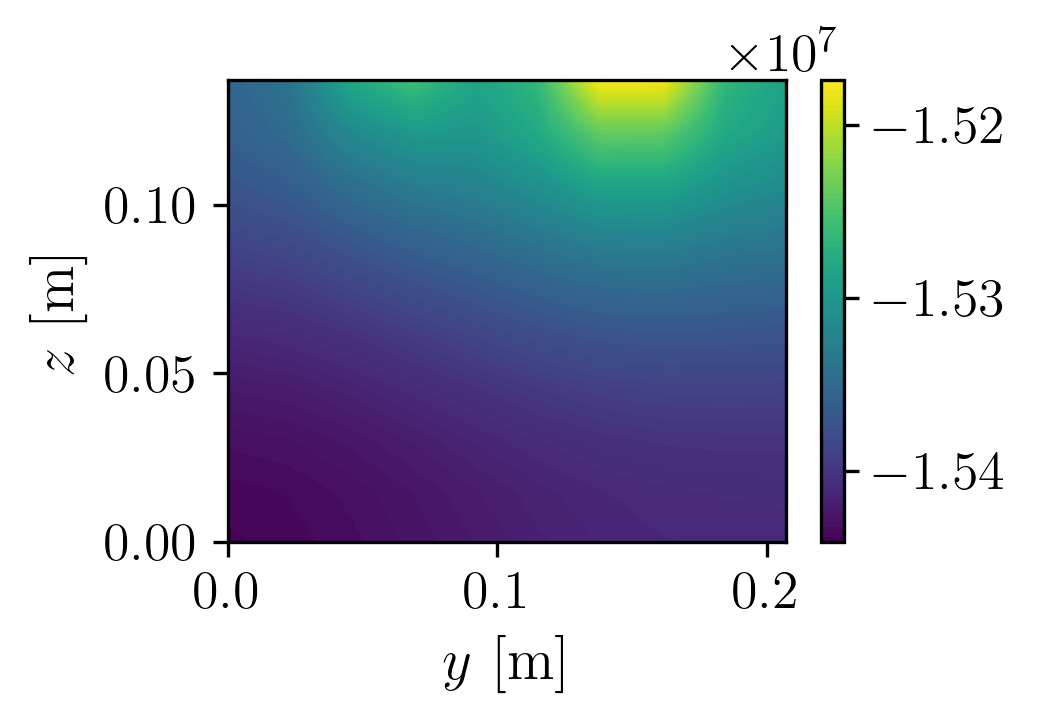

In [8]:

t=60*15

# Mesh for plotting
L_y = parameter_values.evaluate(pybamm.Parameter("Electrode width [m]"))
L_z = parameter_values.evaluate(pybamm.Parameter("Electrode height [m]"))
y_plot = np.linspace(0, L_y, 101)
z_plot = np.linspace(0, L_z, 101)
    
# Evaluate stress and expansion variables at the given time
plot_array = np.array(sol["Negative electrode in-plane stress (yy,zz) [Pa]"](y=y_plot, z=z_plot, t=t)).T

# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(y_plot, z_plot,  plot_array, levels=100, cmap='viridis')  # Using the 'viridis' colormap
plt.colorbar(contour,ticks=np.linspace(-1.52e7, -1.54e7, 3))
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()

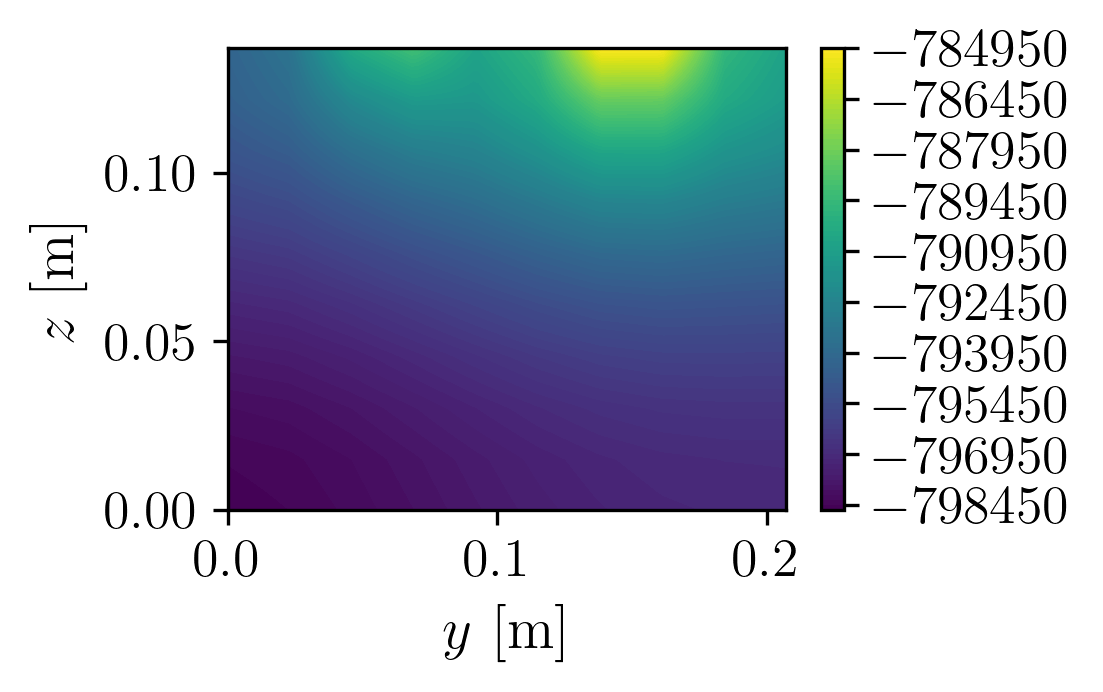

In [9]:


t=60*15

# Mesh for plotting
L_y = parameter_values.evaluate(pybamm.Parameter("Electrode width [m]"))
L_z = parameter_values.evaluate(pybamm.Parameter("Electrode height [m]"))
y_plot = np.linspace(0, L_y, 101)
z_plot = np.linspace(0, L_z, 101)
    
# Evaluate stress and expansion variables at the given time
plot_array = np.array(sol["Positive electrode in-plane stress (yy,zz) [Pa]"](y=y_plot, z=z_plot, t=t)).T

# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(y_plot, z_plot,  plot_array, levels=100, cmap='viridis')  # Using the 'viridis' colormap
plt.colorbar(contour)
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()

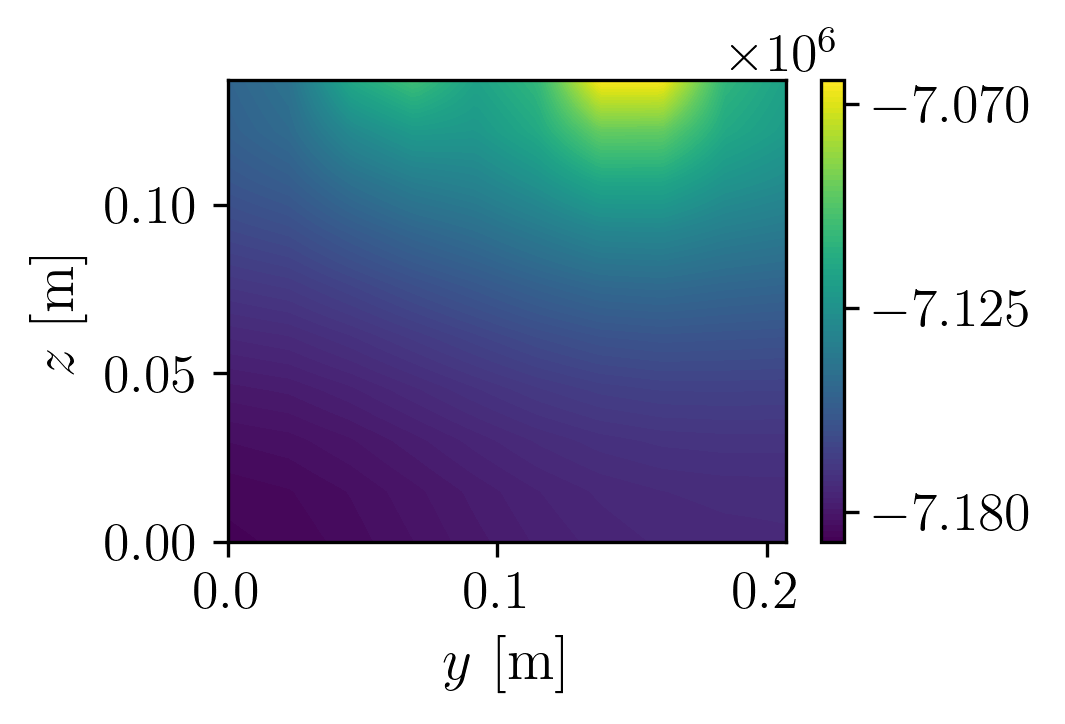

In [10]:

t=60*15

# Mesh for plotting
L_y = parameter_values.evaluate(pybamm.Parameter("Electrode width [m]"))
L_z = parameter_values.evaluate(pybamm.Parameter("Electrode height [m]"))
y_plot = np.linspace(0, L_y, 101)
z_plot = np.linspace(0, L_z, 101)
    
# Evaluate stress and expansion variables at the given time
plot_array = np.array(sol["Negative electrode through-cell stress xx [Pa]"](y=y_plot, z=z_plot, t=t)).T

# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(y_plot, z_plot,  plot_array, levels=100, cmap='viridis')  # Using the 'viridis' colormap
plt.colorbar(contour,ticks=np.linspace(-7.07e6, -7.18e6, 3))
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()

Here we plot the shear stresses. We use a Gaussian smoothing for better presentation.

In [11]:
60*15

# Define plotting function
def plot(solution, t):
    # Post-process variables
    rhoP = solution["Average positive particle stoichiometry"]
    rhoN = solution["Average negative particle stoichiometry"]

    # Mesh for plotting
    L_y = parameter_values["Electrode width [m]"]
    L_z = parameter_values["Electrode height [m]"]
    y_plot = np.linspace(0, L_y, 41)
    z_plot = np.linspace(0, L_z, 41)
    
    # Create figure with subplots arranged horizontally
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Negative current collector potential
    phi_s_cn_plot = ax1.pcolormesh(
        y_plot, z_plot, rhoP(y=y_plot, z=z_plot, t=t).T, shading="gouraud"
    )
    ax1.set_xlabel(r"$y$ [m]")
    ax1.set_ylabel(r"$z$ [m]")
    ax1.set_title(r"$\rho_p$")
    fig.colorbar(phi_s_cn_plot, ax=ax1)

    # Positive current collector potential
    phi_s_cp_plot = ax2.pcolormesh(
        y_plot, z_plot, rhoN(y=y_plot, z=z_plot, t=t).T, shading="gouraud"
    )
    ax2.set_xlabel(r"$y$ [m]")
    ax2.set_ylabel(r"$z$ [m]")
    ax2.set_title(r"$\rho_n$")
    fig.colorbar(phi_s_cp_plot, ax=ax2)
    
    # Adjust layout to fit the subplots neatly
    plt.tight_layout()
    plt.show()

    plot(sol, 0)


We define fucntions FA, FC from equation (86) in the main text.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming alpha, rhoN, concentration functions are defined as per your previous code

time_t=15*60

# Generate a grid of y and z values
y = np.linspace(0, 0.207, 100)
z = np.linspace(0, 0.137, 100)
Y, Z = np.meshgrid(y, z)

# Initialize an empty array for Ff with the same shape as Y and Z
FC = np.zeros_like(Y)

# Iterate over each element in Y and Z
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        # Call the alpha function for each y, z pair and store the result in Ff
        FC[i, j] = 2 * sol["Positive electrode in-plane stress (yy,zz) [Pa]"](y=Y[i, j],z= Z[i, j], t = time_t)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming alpha, rhoN, concentration functions are defined as per your previous code
time_t=15*60

# Generate a grid of y and z values
y = np.linspace(0, 0.207, 100)
z = np.linspace(0, 0.137, 100)
Y, Z = np.meshgrid(y, z)

# Initialize an empty array for Ff with the same shape as Y and Z
FA = np.zeros_like(Y)

# Iterate over each element in Y and Z
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        # Call the alpha function for each y, z pair and store the result in Ff
        FA[i, j] = 2 * sol["Negative electrode in-plane stress (yy,zz) [Pa]"](y=Y[i, j],z= Z[i, j], t = time_t)
from scipy.ndimage import gaussian_filter

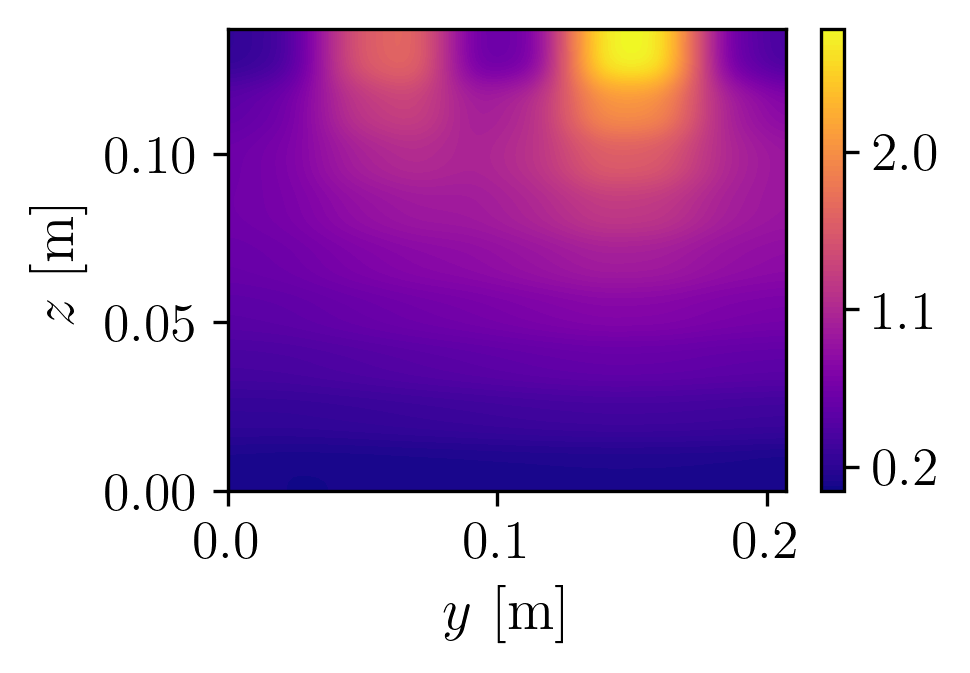

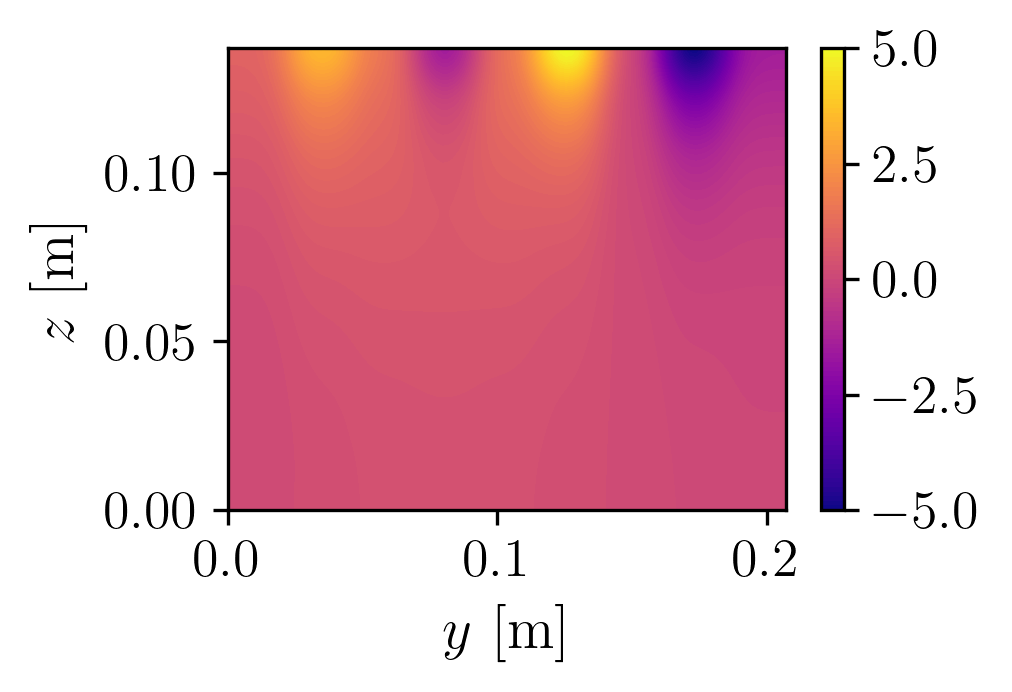

In [14]:
delta = 0.01
#the shear stress is given by half the gradient of FA times delta.

# Compute the gradient of Ff
grad_FC_y, grad_FC_z = np.gradient(FC/2 * delta, y, z, edge_order=2)

# Smooth the gradients
grad_FC_y_smooth = gaussian_filter(grad_FC_y, sigma=3)  # Adjust sigma as needed
grad_FC_z_smooth = gaussian_filter(grad_FC_z, sigma=3)  # Adjust sigma as needed

# Compute the gradient of Ff
grad_FA_y, grad_FA_z = np.gradient(FA/2 * delta, y, z, edge_order=2)

# Smooth the gradients
grad_FA_y_smooth = gaussian_filter(grad_FA_y, sigma=3)  # Adjust sigma as needed
grad_FA_z_smooth = gaussian_filter(grad_FA_z, sigma=3)  # Adjust sigma as needed

# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(Y, Z,  grad_FA_y_smooth/10000, levels=100, cmap='plasma')  # Using the 'viridis' colormap
plt.colorbar(contour,ticks = np.linspace(5.6 ,0.2,7))
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()

# Plot the contour
plt.figure(figsize=(3, 2), dpi=300)
contour = plt.contourf(Y, Z,  grad_FA_z_smooth/10000, levels=100, cmap='plasma')  # Using the 'viridis' colormap
plt.colorbar(contour,ticks = np.linspace(-5 ,5 ,5))
plt.xlabel(r"$y$ [m]")
plt.ylabel(r"$z$ [m]")
plt.show()


In [15]:
# Save the variables FA, Y, Z to a new .npz file
np.savez('FA_data.npz', FA=FA, Y=Y, Z=Z)